In [5]:
import os, random, glob, pickle, collections
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from skimage.data import imread
from skimage.io import imshow,imsave
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import math

In [2]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
TRAIN_CROP_DIR = '../data/train_crop/'
TEST_CROP_DIR = '../data/test_stg1_crop/'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 270
COLS = 480
BatchSize = 64
LearningRate = 1e-4
le = LabelEncoder()
le.fit(FISH_CLASSES)
le.transform(FISH_CLASSES)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [20]:
#crop and cache to TRAIN_CROP_DIR by BBannotations
if not os.path.exists(TRAIN_CROP_DIR):
    os.mkdir(TRAIN_CROP_DIR)

for c in FISH_CLASSES:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    if not os.path.exists(TRAIN_CROP_DIR_c):
        os.mkdir(TRAIN_CROP_DIR_c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for f in files:
        os.remove(f)
        
crop_classes=FISH_CLASSES[:]
crop_classes.remove('NoF')
count = {}

for c in crop_classes:
    j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
    for l in j: 
        filename = l["filename"]
        head, tail = os.path.split(filename)
        basename, file_extension = os.path.splitext(tail) 
        image = Image.open(TRAIN_DIR+c+'/'+tail)
        for i in range(len(l["annotations"])):
            a = l["annotations"][i]
            file_crop = TRAIN_CROP_DIR + '{}/'.format(a["class"])+c+'_'+basename+'_{}_'.format(i)+a["class"]+'.jpg'
            xmin = (a["x"])
            ymin = (a["y"])
            width = (a["width"])
            height = (a["height"])
            xmax = xmin + width
            ymax = ymin + height
            #save cropped img
            cropped = image.crop((max(xmin,0), max(ymin,0), xmax, ymax))
            #cropped = image[max(ymin,0):ymax, max(xmin,0):xmax]
            width_cropped, height_cropped = cropped.size
            if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
            cropped.save(file_crop)
            if a["class"] != c: print(file_crop)
    count[c] = len(os.listdir(TRAIN_CROP_DIR+c))


    
count['NoF'] = len(os.listdir(TRAIN_CROP_DIR+'NoF'))
print(count)

../data/train_crop/LAG/ALB_img_01800_6_LAG.jpg
../data/train_crop/LAG/ALB_img_03397_1_LAG.jpg
../data/train_crop/LAG/ALB_img_03451_1_LAG.jpg
../data/train_crop/LAG/ALB_img_03748_4_LAG.jpg
../data/train_crop/ALB/DOL_img_07212_1_ALB.jpg
../data/train_crop/ALB/DOL_img_07212_2_ALB.jpg
../data/train_crop/LAG/SHARK_img_06082_0_LAG.jpg
../data/train_crop/ALB/SHARK_img_06082_1_ALB.jpg
../data/train_crop/ALB/SHARK_img_06082_2_ALB.jpg


{'ALB': 2509,
 'BET': 306,
 'DOL': 126,
 'LAG': 104,
 'OTHER': 333,
 'SHARK': 189,
 'YFT': 799}

In [28]:
#crop and cache to TRAIN_CROP_DIR/NoF by RFCN
#crop images by detections_full_AGNOSTICnms.pkl

RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.999
outputs = []

for im in range(len(detections_full_AGNOSTICnms)):
    outputs_im = []
    detects_im = detections_full_AGNOSTICnms[im]
    for i in range(len(detects_im)):
        if np.max(detects_im[i,4]) >= CONF_THRESH:
            outputs_im.append(detects_im[i,:]) 
    outputs_im = np.asarray(outputs_im)
    outputs_im[np.random.randint(outputs_im.shape[0], size=1), :]
    outputs.append(outputs_im[np.random.randint(outputs_im.shape[0], size=1), :])

train_outputs = outputs[1000:] 

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
train_files = [im[:-1]+'.jpg' for im in ims][1000:]

for i in range(len(train_outputs)):
    filename = train_files[i]
    print(i,)
    bboxes = train_outputs[i]
    basename, file_extension = os.path.splitext(filename) 
    image = Image.open(TEST_DIR+filename)
    for j in range(len(bboxes)):
        bbox = bboxes[j]
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]
        ymax = bbox[3]
        file_crop = TRAIN_CROP_DIR+'NoF/'+basename+'_{}_'.format(j)+'.jpg'
        cropped = image.crop((xmin, ymin, xmax, ymax))
        width_cropped, height_cropped = cropped.size
        if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
        cropped.save(file_crop)  

3777
3777
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


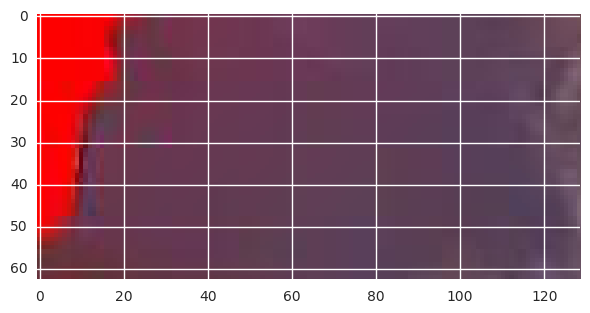

In [33]:
ims = os.listdir(TRAIN_CROP_DIR+'NoF')
im = Image.open('../data/train_crop/NoF/'+ims[2])
imshow(np.asarray(im))

In [ ]:
im = Image.open('../data/train_crop/ALB/SHARK_img_06082_2_ALB.jpg')
imshow(np.asarray(im))

im_sizes = []
for c in crop_classes:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for file in files:
        im = Image.open(file)
        #size = (width, height)
        size = im.size
        im_sizes.append(size)
im_sizes = np.asarray(im_sizes)

len(im_sizes)

np.mean(im_sizes[:,1]/im_sizes[:,0])

plt.hist(im_sizes[:,1]/im_sizes[:,0], bins=10)

plt.scatter(im_sizes[:,0],im_sizes[:,1]) 

In [4]:
#Loading data
import pickle

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_CROP_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_train_BBCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_train = pickle.load(f)
    X_train = data_train['X_train']
    y_train = data_train['y_train']
else:
    print ('Loading data from original images. Generating data_train_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))
    
    files = []
    y_train = []

    for fish in FISH_CLASSES:
        fish_files = get_images(fish)
        files.extend(fish_files)

        y_fish = np.tile(fish, len(fish_files))
        y_train.extend(y_fish)
        #print("{0} photos of {1}".format(len(fish_files), fish))

    y_train = np.array(y_train)
    X_train = np.ndarray((len(files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(files): 
        X_train[i] = read_image(TRAIN_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

    #X_train = X_train / 255.
    #print(X_train.shape)

    # One Hot Encoding Labels
    y_train = le.transform(y_train)
    y_train = np_utils.to_categorical(y_train)
    
    #save data to file
    data_train = {'X_train': X_train,'y_train': y_train }

    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_train, f)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=None, stratify=y_train)

Exist data_train_BBCrop_270_480.pickle. Loading data from file.


In [5]:
#data preprocessing

train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

#train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [6]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


In [9]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output

#x = MaxPooling2D()(x)
#x = BatchNormalization()(x)
#x = Flatten()(x)
#x = Dense(512, activation='relu', init='glorot_normal')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Epoch 1/300
3840/3868 [============================>.] - ETA: 0s - loss: 1.9705 - acc: 0.3609

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 2.19270, saving model to ./checkpoints/weights.000-2.1927.hdf5
3904/3868 [==============================] - 177s - loss: 1.9661 - acc: 0.3619 - val_loss: 2.1927 - val_acc: 0.4805
Epoch 2/300
3904/3868 [==============================] - 166s - loss: 1.5496 - acc: 0.5015 - val_loss: 1.9034 - val_acc: 0.5322
Epoch 3/300
3924/3868 [==============================] - 168s - loss: 1.3981 - acc: 0.5456 - val_loss: 1.8312 - val_acc: 0.5273
Epoch 4/300
3904/3868 [==============================] - 166s - loss: 1.2819 - acc: 0.5935 - val_loss: 1.8042 - val_acc: 0.5186
Epoch 5/300
3904/3868 [==============================] - 165s - loss: 1.2502 - acc: 0.5978 - val_loss: 1.8170 - val_acc: 0.5088
Epoch 6/300
3924/3868 [==============================] - 166s - loss: 1.1451 - acc: 0.6205 - val_loss: 1.7337 - val_acc: 0.5361
Epoch 7/300
3904/3868 [==============================] - 165s - loss: 1.1076 - acc: 0.6360 - val_loss: 1.7609 - val_acc: 0.5273
Epoch 8/30

In [10]:
#Resnet50
#stg2 training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:164]:
   layer.trainable = False
for layer in model.layers[164:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Loading model from checkpoints file ./checkpoints/weights.040-0.6054.hdf5
0 input_2
1 zeropadding2d_2
2 conv1
3 bn_conv1
4 activation_50
5 maxpooling2d_2
6 res2a_branch2a
7 bn2a_branch2a
8 activation_51
9 res2a_branch2b
10 bn2a_branch2b
11 activation_52
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 merge_17
17 activation_53
18 res2b_branch2a
19 bn2b_branch2a
20 activation_54
21 res2b_branch2b
22 bn2b_branch2b
23 activation_55
24 res2b_branch2c
25 bn2b_branch2c
26 merge_18
27 activation_56
28 res2c_branch2a
29 bn2c_branch2a
30 activation_57
31 res2c_branch2b
32 bn2c_branch2b
33 activation_58
34 res2c_branch2c
35 bn2c_branch2c
36 merge_19
37 activation_59
38 res3a_branch2a
39 bn3a_branch2a
40 activation_60
41 res3a_branch2b
42 bn3a_branch2b
43 activation_61
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 merge_20
49 activation_62
50 res3b_branch2a
51 bn3b_branch2a
52 activation_63
53 res3b_branch2b
54 bn3b_branch2b
55 activation_64
56 res3b

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from 0.60545 to 0.56201, saving model to ./checkpoints/weights.000-0.5620.hdf5
3904/3868 [==============================] - 188s - loss: 0.6358 - acc: 0.7800 - val_loss: 0.5620 - val_acc: 0.8115
Epoch 2/300
3904/3868 [==============================] - 172s - loss: 0.5393 - acc: 0.8179 - val_loss: 0.5513 - val_acc: 0.8154
Epoch 3/300
3924/3868 [==============================] - 174s - loss: 0.4591 - acc: 0.8415 - val_loss: 0.4309 - val_acc: 0.8535
Epoch 4/300
3904/3868 [==============================] - 172s - loss: 0.3630 - acc: 0.8788 - val_loss: 0.4506 - val_acc: 0.8496
Epoch 5/300
3904/3868 [==============================] - 172s - loss: 0.3015 - acc: 0.8960 - val_loss: 0.3996 - val_acc: 0.8691
Epoch 6/300
3924/3868 [==============================] - 173s - loss: 0.2616 - acc: 0.9118 - val_loss: 0.3871 - val_acc: 0.8779
Epoch 7/300
3904/3868 [==============================] - 173s - loss: 0.2157 - acc: 0.9293 - val_loss: 0.3614 - val_acc: 0.8936
Epoch 

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [3]:
#get bbox from detections_full.pkl and RFCN/ImageSets/Main/test.txt
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFNC_detections/detections_full.pkl','rb') as f:
    detections_full = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.8
outputs = []

for im in range(len(detections_full[0])):
#for im in range(1):
    outputs_im = []
    detects_im = []
    for cls in range(1,len(FISH_CLASSES)):
        detects_im_cls = detections_full[cls][im]
        for i in range(len(detects_im_cls)):
            if np.max(detects_im_cls[i,4+cls]) >= CONF_THRESH:
                outputs_im.append(detects_im_cls[i,:])   
    for cls in range(1,len(FISH_CLASSES)):  
        detects_im.append(detections_full[cls][im])
    detects_im = np.vstack(detects_im)
    if len(outputs_im) == 0:
        ind = np.argmax(np.max(detects_im[:,5:], axis=1))
        l = [0,0,0,0]
        l.extend(np.ndarray.tolist(detects_im[ind,4:]))
        outputs_im.append(l)
    outputs_im = np.asarray(outputs_im)
    outputs.append(outputs_im)

print(sum([outputs[i].shape[0] for i in range(len(outputs))]))


5940


In [7]:
#Load test data

import datetime

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_BBCrop_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test_crop = data_test['X_test_crop']
    test_crop_files = data_test['test_crop_files']
else:
    print ('Loading test data from original images. Generating data_test_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))

    test_crop_files = [im for im in os.listdir(TEST_CROP_DIR)]
    X_test_crop = np.ndarray((len(test_crop_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_crop_files): 
        X_test_crop[i] = read_image(TEST_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(test_crop_files)))
            
    data_test = {'X_test_crop': X_test_crop,'test_crop_files': test_crop_files }
    
    with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f, protocol=4)
        
X_test_crop = X_test_crop / 255.

Loading test data from original images. Generating data_test_BBCrop_270_480.pickle.
Processed 0 of 5940
Processed 1000 of 5940
Processed 2000 of 5940
Processed 3000 of 5940
Processed 4000 of 5940
Processed 5000 of 5940


MemoryError: 

In [20]:
#test preds

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from', files[index])
model = load_model(files[index])

test_crop_preds = model.predict(X_test_crop, batch_size=BatchSize, verbose=1)

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

test_preds = np.ndarray((len(test_files), test_crop_preds.shape[1]), dtype=np.float32)
for j in range(len(test_files)):
    file = test_files[j]
    test_preds_im = []
    for i in range(len(test_crop_files)):
        if test_crop_files[i][:9] == file[:9]:
            test_preds_im.append(test_crop_preds[i])
    test_preds_im = np.asarray(test_preds_im)
    test_preds_im = np.mean(test_preds_im, axis=0)
    test_preds[j] = test_preds_im

Loading model from ./checkpoints/weights.017-0.1933.hdf5
8216/8216 [==============================] - 231s   


In [22]:
#calculate train logloss
train_files = test_files[1000:]
train_preds = test_preds[1000:,:]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i][:-4]
    for im_label in train_file_labels:
        if im_label[:9] == im:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i,index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

3777
logloss of train is 0.692274711996035


In [23]:
#test submission
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(test_preds[:1000,:], columns=FISH_CLASSES)
submission.insert(0, 'image', test_files[:1000])

now = datetime.datetime.now()
info = 'BBCROP_resnet50_' + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

In [7]:
###clear checkpoints folder

if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
files = glob.glob('./checkpoints/*')
for f in files:
    os.remove(f)

In [8]:
###clear logs folder

if not os.path.exists('./logs'):
    os.mkdir('./logs')
files = glob.glob('./logs/*')
for f in files:
    os.remove(f)